## Rendering with instanced geometries

This test demonstrates rendering with multi-level instancing.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lmenv
env = lmenv.load('.lmenv')

In [3]:
# Imports
import os
import traceback
import imageio
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lmscene
import lightmetrica as lm

In [4]:
os.getpid()

263

In [5]:
%load_ext lightmetrica_jupyter

In [6]:
# Initialize Lightmetrica
lm.init()
lm.log.init('jupyter')
lm.progress.init('jupyter')

In [7]:
lm.comp.load_plugin(os.path.join(env.bin_path, 'accel_embree'))
lm.comp.load_plugin(os.path.join(env.bin_path, 'accel_nanort'))

[I|0.016] Loading plugin [name='accel_embree']
[I|0.017] .. Successfully loaded [name='accel_embree']
[I|0.017] Loading plugin [name='accel_nanort']
[I|0.017] .. Successfully loaded [name='accel_nanort']


In [8]:
if not lm.Release:
    lm.parallel.init('openmp', num_threads=1)
    lm.debug.attach_to_debugger()

In [9]:
# Create a sphere geometry with triangle mesh
r = 1
numTheta = 10
numPhi = 2*numTheta
vs = np.zeros((numPhi*(numTheta+1), 3))
ns = np.zeros((numPhi*(numTheta+1), 3))
ts = np.zeros((numPhi*(numTheta+1), 2))
for i in range(numTheta+1):
    for j in range(numPhi):
        theta = i*np.pi/numTheta
        phi = j*2*np.pi/numPhi
        idx = i*numPhi+j
        ns[idx,0] = np.sin(theta)*np.sin(phi)
        ns[idx,1] = np.cos(theta)
        ns[idx,2] = np.sin(theta)*np.cos(phi)
        vs[idx,0] = r*ns[idx,0]
        vs[idx,1] = r*ns[idx,1]
        vs[idx,2] = r*ns[idx,2]

fs = np.zeros((2*numPhi*(numTheta-1), 3), dtype=np.int32)
idx = 0
for i in range(1,numTheta+1):
    for j in range(1,numPhi+1):
        p00 = (i-1)*numPhi+j-1
        p01 = (i-1)*numPhi+j%numPhi
        p10 = i*numPhi+j-1
        p11 = i*numPhi+j%numPhi
        if i > 1:
            fs[idx,:] = np.array([p10,p01,p00])
            idx += 1
        if i < numTheta:
            fs[idx,:] = np.array([p11,p01,p10])
            idx += 1

In [10]:
accel = lm.load_accel('accel', 'nanort')
scene = lm.load_scene('scene', 'default', accel=accel)
mesh = lm.load_mesh('mesh_sphere', 'raw',
    ps=vs.flatten().tolist(),
    ns=ns.flatten().tolist(),
    ts=ts.flatten().tolist(),
    fs={
        'p': fs.flatten().tolist(),
        't': fs.flatten().tolist(),
        'n': fs.flatten().tolist()
    })
camera = lm.load_camera('camera_main', 'pinhole',
    position=[0,0,50],
    center=[0,0,0],
    up=[0,1,0],
    vfov=30,
    aspect=16/9)
material = lm.load_material('material_white', 'diffuse', Kd=[1,1,1])
film = lm.load_film('film_output', 'bitmap', w=1920, h=1080)
renderer = lm.load_renderer('renderer', 'raycast',
    scene=scene,
    output=film,
    visualize_normal=True,
    bg_color=[1,1,1])

[I|0.077] Loading asset [name='accel']
[I|0.078] Loading asset [name='scene']
[I|0.078] Loading asset [name='mesh_sphere']
[I|0.079] Loading asset [name='camera_main']
[I|0.079] Loading asset [name='material_white']
[I|0.079] Loading asset [name='film_output']
[I|0.157] Loading asset [name='renderer']


### Without instancing

In [11]:
scene.reset()
scene.add_primitive(camera=camera)

for y in np.linspace(-10,10,10):
    for x in np.linspace(-10,10,10):
        p = scene.create_primitive_node(mesh=mesh, material=material)
        t = scene.create_group_node(lm.translate(np.array([x,y,0])))
        scene.add_child(t, p)
        scene.add_child(scene.root_node(), t)
        
scene.build()
renderer.render()

[I|0.178] Building acceleration structure [name='accel']
[I|0.178] .. Flattening scene
[I|0.182] .. Building


  0%|          | 0/2073600 [00:00<?, ?it/s]

{'elapsed': 1.157075031}

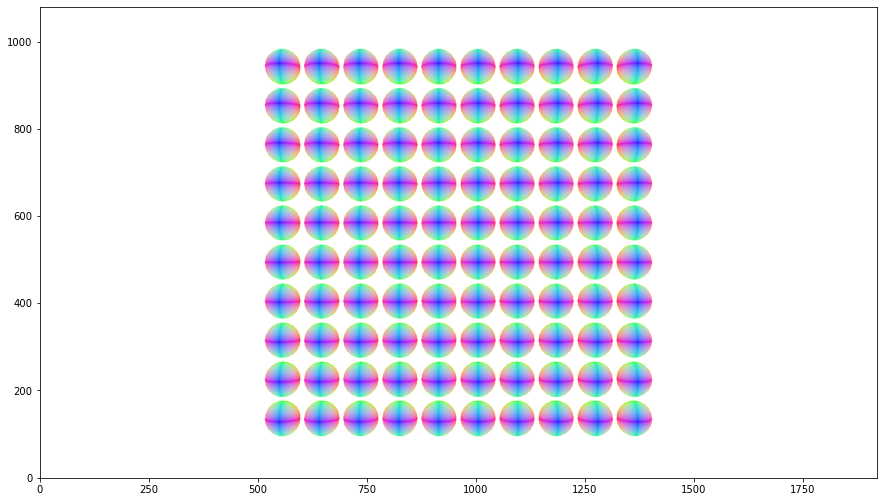

In [12]:
img = np.copy(film.buffer())
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
ax.imshow(np.clip(np.power(img,1/2.2),0,1), origin='lower')
plt.show()


### Single-level

In [13]:
scene.reset()
scene.add_primitive(camera=camera)

# Instance group
g = scene.create_instance_group_node()
scene.add_child(g, scene.create_primitive_node(mesh=mesh, material=material))

# Transformed instanced group
for y in np.linspace(-10,10,10):
    for x in np.linspace(-10,10,10):
        t = scene.create_group_node(lm.translate(np.array([x,y,0])))
        scene.add_child(t, g)
        scene.add_child(scene.root_node(), t)
        
scene.build()
renderer.render()

[I|2.511] Building acceleration structure [name='accel']
[I|2.511] .. Flattening scene
[I|2.512] .. Building


  0%|          | 0/2073600 [00:00<?, ?it/s]

{'elapsed': 1.147292915}

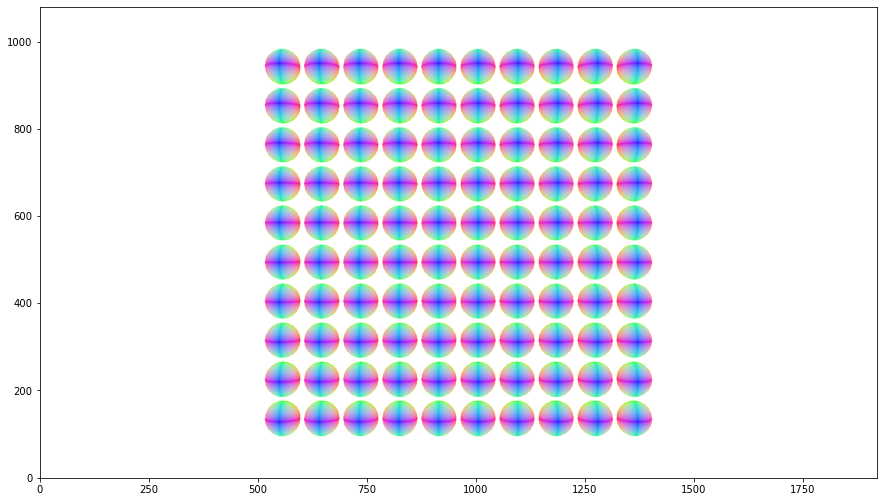

In [14]:
img = np.copy(film.buffer())
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
ax.imshow(np.clip(np.power(img,1/2.2),0,1), origin='lower')
plt.show()

### Multi-level

In [15]:
scene.reset()
scene.add_primitive(camera=camera)

# Initial group
g1 = scene.create_instance_group_node()
scene.add_child(g1, scene.create_primitive_node(mesh=mesh, material=material))

# Second group using initial group as chilren
g2 = scene.create_instance_group_node()
for y in np.linspace(-10,10,10):
    t = scene.create_group_node(lm.translate(np.array([0,y,0])))
    scene.add_child(t, g1)
    scene.add_child(g2, t)
    
# Add transformed second group to the root node
for x in np.linspace(-10,10,10):
    t = scene.create_group_node(lm.translate(np.array([x,0,0])))
    scene.add_child(t, g2)
    scene.add_child(scene.root_node(), t)   
    
scene.build()
renderer.render()

[I|4.780] Building acceleration structure [name='accel']
[I|4.780] .. Flattening scene
[I|4.782] .. Building


  0%|          | 0/2073600 [00:00<?, ?it/s]

{'elapsed': 1.12509472}

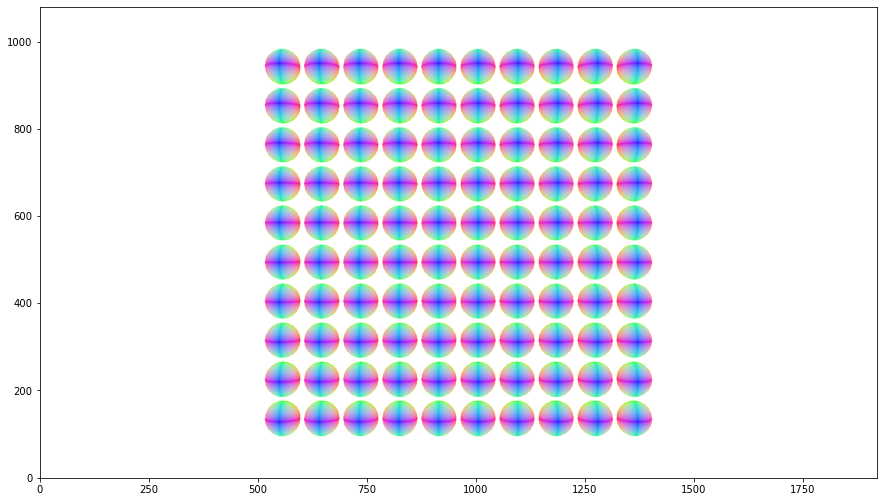

In [16]:
img = np.copy(film.buffer())
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
ax.imshow(np.clip(np.power(img,1/2.2),0,1), origin='lower')
plt.show()